source: http://archive.ics.uci.edu/ml/machine-learning-databases/adult/

In [1]:
import pandas as pd
import numpy as np

cols = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation",
"relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country", "target"]
df = pd.read_csv("adult.data", names=cols, index_col=False)

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = df[col].str.strip()
        
df.replace("?", np.NaN, inplace=True)        

print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
int_columns = df.select_dtypes(['int64']).columns

In [3]:
df.dropna(inplace=True)
print(df.shape)

(30162, 15)


In [4]:
df[["education", "education-num"]].groupby(["education"])["education-num"].max().sort_values()

education
Preschool        1
1st-4th          2
5th-6th          3
7th-8th          4
9th              5
10th             6
11th             7
12th             8
HS-grad          9
Some-college    10
Assoc-voc       11
Assoc-acdm      12
Bachelors       13
Masters         14
Prof-school     15
Doctorate       16
Name: education-num, dtype: int64

# Features engineering

In [5]:
y = df['target'].copy()
df.drop(['target'], axis=1, inplace=True)

from sklearn import preprocessing
y_le = preprocessing.LabelEncoder()
y_le.fit(y)
print("classes", y_le.classes_)

y = y_le.transform(y)
print("inv. transform example", y_le.inverse_transform([0, 0, 1]))

classes ['<=50K' '>50K']
inv. transform example ['<=50K' '<=50K' '>50K']


In [6]:
for col in df.columns:
    if df[col].dtype == "object":
        temp_df = pd.get_dummies(df[col], prefix=col)
        df = pd.concat([df, temp_df], axis=1)
        df.drop([col], axis=1, inplace=True)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.33, random_state=42)
X_train, X_test = X_train.copy(), X_test.copy()  # Copy to get rid of the "settingwithcopywarning" warning

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train[int_columns])

X_train[int_columns] = scaler.transform(X_train[int_columns])
X_test[int_columns] = scaler.transform(X_test[int_columns])

# X_train[int_columns].std(axis=0)

# Feature selection

/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: Convergence

1000


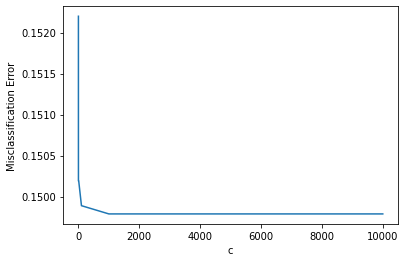

In [100]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

c_list = [0.1, 0.5, 1, 10, 100, 1000, 10000]
scores = []
for c in c_list:
    clf = LogisticRegression(C=c, solver='saga', penalty='l1')
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, pred))

#misclassification error
MSE = [1-x for x in scores]

#optimal C
optimal_c_index = MSE.index(min(MSE))
optimal_c = c_list[optimal_c_index]
print(optimal_c)

# plot misclassification error vs D
plt.plot(c_list, MSE)
plt.xlabel('c')
plt.ylabel('Misclassification Error')
plt.show()

In [101]:
clf = LogisticRegression(C=1000, solver='saga', penalty='l1')
clf.fit(X_train, y_train)
coefs = sorted(list(zip(clf.coef_.T, X_train.columns)),reverse =True, key=lambda x: x[0][0])
pd.DataFrame([[c[1], c[0][0]] for c in coefs[:10]], columns=["coef. name", "value"])

/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


,coef. name,value
0,capital-gain,2.412163
1,marital-status_Married-AF-spouse,1.806138
2,marital-status_Married-civ-spouse,1.382116
3,native-country_Italy,1.320832
4,native-country_Yugoslavia,1.150745
5,occupation_Exec-managerial,0.861541
6,relationship_Wife,0.839695
7,education-num,0.739736
8,occupation_Tech-support,0.706291
9,native-country_France,0.676096


In [115]:
# See top coefficients which pushes our classifier to the class ">50K"
coefs = sorted(list(zip(clf.coef_.T, X_train.columns)),reverse=True, key=lambda x: x[0][0])
top_pos_cols = [c[1] for c in coefs[:10]]
pd.DataFrame([[c[1], c[0][0]] for c in coefs[:10]], columns=["coef. name", "value"])

,coef. name,value
0,capital-gain,2.412163
1,marital-status_Married-AF-spouse,1.806138
2,marital-status_Married-civ-spouse,1.382116
3,native-country_Italy,1.320832
4,native-country_Yugoslavia,1.150745
5,occupation_Exec-managerial,0.861541
6,relationship_Wife,0.839695
7,education-num,0.739736
8,occupation_Tech-support,0.706291
9,native-country_France,0.676096


In [118]:
# See top coefficients which pushes our classifier to the class "<=50K"
coefs = sorted(list(zip(clf.coef_.T, X_train.columns)),reverse=False, key=lambda x: x[0][0])
top_neg_cols = [c[1] for c in coefs[:10]]
pd.DataFrame([[c[1], c[0][0]] for c in coefs[:10]], columns=["coef. name", "value"])

,coef. name,value
0,occupation_Priv-house-serv,-1.817848
1,native-country_Columbia,-1.548501
2,marital-status_Never-married,-1.342005
3,native-country_Vietnam,-1.253280
4,education_Preschool,-1.223461
5,sex_Female,-1.119564
6,occupation_Farming-fishing,-1.072207
7,relationship_Own-child,-0.988294
8,marital-status_Separated,-0.940812
9,native-country_Dominican-Republic,-0.888783


# Hyper parameters tuning

/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear

1


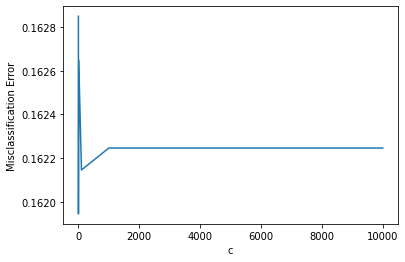

In [123]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

top_cols = top_pos_cols + top_neg_cols

c_list = [0.1, 0.5, 1, 10, 100, 1000, 10000]
scores = []
for c in c_list:
    clf = LogisticRegression(C=c)
    clf.fit(X_train[top_cols], y_train)
    pred = clf.predict(X_test[top_cols])
    scores.append(accuracy_score(y_test, pred))

#misclassification error
MSE = [1-x for x in scores]

#optimal C
optimal_c_index = MSE.index(min(MSE))
optimal_c = c_list[optimal_c_index]
print(optimal_c)

# plot misclassification error vs D
plt.plot(c_list, MSE)
plt.xlabel('c')
plt.ylabel('Misclassification Error')
plt.show()

# Train classifier with the optimal configuration  

In [99]:
scaler = StandardScaler()
df[int_columns] = scaler.fit_transform(df[int_columns])

clf = LogisticRegression(C=10)
clf.fit(df, y)

/home/yuri/.virtualenvs/ml/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# Testing

In [11]:
tf = pd.read_csv("adult.test", names=cols, index_col=False, skiprows=1)

for col in tf.columns:
    if tf[col].dtype == "object":
        tf[col] = tf[col].str.strip()
        
tf.replace("?", np.NaN, inplace=True)        

print(tf.shape)
tf.head()

(16281, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


In [12]:
# Show wrong class names problem
print(tf.target.value_counts())
print(y_le.classes_)

# Fix
tf.target = tf.target.apply(lambda x: '<=50K' if x == '<=50K.' else '>50K')

# Check fix
print(tf.target.value_counts())

<=50K.    12435
>50K.      3846
Name: target, dtype: int64
['<=50K' '>50K']
<=50K    12435
>50K      3846
Name: target, dtype: int64


In [13]:
tf.dropna(inplace=True)
print(tf.shape)

(15060, 15)


In [14]:
ty = tf['target'].copy()
tf.drop(['target'], axis=1, inplace=True)

ty = y_le.transform(ty)

In [15]:
for col in tf.columns:
    if tf[col].dtype == "object":
        temp_df = pd.get_dummies(tf[col], prefix=col)
        tf = pd.concat([tf, temp_df], axis=1)
        tf.drop([col], axis=1, inplace=True)

In [16]:
# Fix missing feature
tf['Holand-Netherlands'] = 0

In [17]:
tf[int_columns] = scaler.transform(tf[int_columns])

In [96]:
from sklearn.metrics import confusion_matrix
pred = clf.predict(tf)
print(1 - accuracy_score(ty, pred))
print(confusion_matrix(ty, pred))

0.16069057104913675
[[10956   404]
 [ 2016  1684]]


,coef. name,value
0,capital-gain,2.348290
1,marital-status_Married-AF-spouse,1.997909
2,native-country_Cambodia,1.325787
3,marital-status_Married-civ-spouse,1.259425
4,native-country_Italy,0.977983
5,relationship_Wife,0.943587
6,occupation_Exec-managerial,0.920772
7,native-country_France,0.882733
8,native-country_Yugoslavia,0.839198
9,occupation_Tech-support,0.768940


In [71]:
X_train.mean()

age                               1.844218e-16
fnlwgt                            8.612050e-17
education-num                    -3.560537e-16
capital-gain                     -7.964015e-16
capital-loss                     -1.717610e-16
                                      ...     
native-country_Thailand           6.927949e-04
native-country_Trinadad&Tobago    4.948535e-04
native-country_United-States      9.090459e-01
native-country_Vietnam            2.177356e-03
native-country_Yugoslavia         4.453682e-04
Length: 104, dtype: float64

20208